In [39]:
import matplotlib
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from collections import defaultdict
from typing import Sequence


from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

import numpy as np
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, Session, EstimatorV2 as Estimator, SamplerV2 as Sampler
from qiskit_aer import AerSimulator
from scipy.optimize import minimize

In [40]:
# ----- Problem setup ---- #
n_assets = 2
num_qubits = 2 * n_assets  # 4 portfolio qubits
target_sum = 1
lambda_param = 0.5  # Risk aversion parameter
cov = np.array([[0.1, 0.05], [0.05, 0.2]])
returns = np.array([0.1, 0.15])

def z_op(a):
    # Returns (pauli_type, qubit_index, coefficient)
    return [('Z', 2*a, -1), ('Z', 2*a+1, 1)]

def build_pauli_list(n_assets, cov, returns, lambda_param):
    pauli_list = []
    # Covariance terms (risk)
    for i in range(n_assets):
        for j in range(n_assets):
            w = cov[i][j]
            if abs(w) > 1e-9:
                for ti, idxi, ci in z_op(i):
                    for tj, idxj, cj in z_op(j):
                        if ti == 'Z' and tj == 'Z' and idxi != idxj:
                            factor = ci * cj * lambda_param * w / 4
                            pauli_list.append(('ZZ', [idxi, idxj], factor))
    # Linear return terms
    for i in range(n_assets):
        for t, idx, c in z_op(i):
            pauli_list.append((t, [idx], - (1 - lambda_param) * returns[i] * c / 2))
    # No penalty terms for QAOAz, constraint enforced by mixer and initial state
    return pauli_list

all_paulis = build_pauli_list(n_assets, cov, returns, lambda_param)
cost_hamiltonian = SparsePauliOp.from_sparse_list(all_paulis, num_qubits)
print("Hamiltonian:", cost_hamiltonian)

Hamiltonian: SparsePauliOp(['IIZZ', 'IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZIZI', 'IZIZ', 'IZZI', 'ZIIZ', 'ZIZI', 'ZZII', 'ZZII', 'IIIZ', 'IIZI', 'IZII', 'ZIII'],
              coeffs=[-0.0125 +0.j, -0.0125 +0.j,  0.00625+0.j, -0.00625+0.j, -0.00625+0.j,
  0.00625+0.j,  0.00625+0.j, -0.00625+0.j, -0.00625+0.j,  0.00625+0.j,
 -0.025  +0.j, -0.025  +0.j,  0.025  +0.j, -0.025  +0.j,  0.0375 +0.j,
 -0.0375 +0.j])


In [41]:
# ---- IBM Quantum authentication ----
# Note: Use your actual API key and CRN. The provided ones are placeholders.
your_api_key = "BqMuCCF0_M2P5dzoNApDTGg28J61TeNul9-f8QPlfLiD"
your_crn = "crn:v1:bluemix:public:quantum-computing:us-east:a/c8622f9882a44fee81dc9875e59b2e91:73c0e342-5c00-401f-82b2-d284f39252e2::"
QiskitRuntimeService.save_account(
    channel="ibm_cloud",
    token=your_api_key,
    instance=your_crn,
    overwrite=True
)

In [42]:
service = QiskitRuntimeService()

# -------- Backend selection -------- #
#backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
#backend = AerSimulator.from_backend(backend) 
backend = AerSimulator()# Simulate with noise
print(f"Using backend: {backend.name}")

# ----- QAOAz Ansatz ---- #
p = 2

# Prepare initial state
initial = QuantumCircuit(4)
initial.x(1)
initial.h(2)
initial.cx(2, 3)

# Mixer Hamiltonian for dual parity ring (coefficients adjusted for ring structure)
mixer_paulis = [
    ('XX', [0, 2], 2.0), ('YY', [0, 2], 2.0),
    ('XX', [1, 3], 2.0), ('YY', [1, 3], 2.0)
]
mixer = SparsePauliOp.from_sparse_list(mixer_paulis, num_qubits)

Using backend: aer_simulator


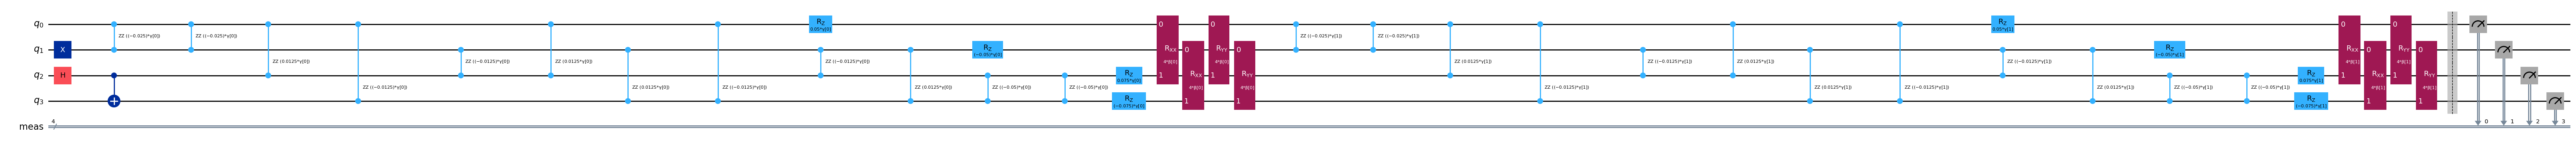

In [43]:
ansatz = QAOAAnsatz(cost_hamiltonian, reps=p, initial_state=initial, mixer_operator=mixer)
ansatz.measure_all()
init_params = np.random.uniform(0, np.pi, ansatz.num_parameters)

delta_gamma, delta_beta = 0.1,0.1

initial_gamma = [(1 + i)*delta_gamma/p for i in range(p)]
initial_beta = [(1 - i/p)*delta_beta for i in range(p)]


init_params = [val for i in range(p) for val in (initial_gamma[i], initial_beta[i])]

pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
candidate_circuit = pm.run(ansatz)
candidate_circuit.draw("mpl", fold=False, idle_wires=False)

In [20]:
"""
def cost_func(params, ansatz, hamiltonian, estimator):
    isa_hamiltonian = cost_hamiltonian.apply_layout(ansatz.layout)
    pub = (candidate_circuit, isa_hamiltonian, params)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    objective_func_vals.append(cost)
    
    return cost

In [21]:
"""
objective_func_vals = []
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000
    
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

   
    result = minimize(cost_func, init_params, args=(candidate_circuit, cost_hamiltonian, estimator),
                      method='COBYLA', tol=1e-3, options={"maxiter": 200})
    print("Optimal QAOAz params:", result)

C:\Users\PC\anaconda3\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:273: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


Optimal QAOAz params:  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.02500000000000001
       x: [ 1.567e+00  2.179e+00]
    nfev: 25
   maxcv: 0.0


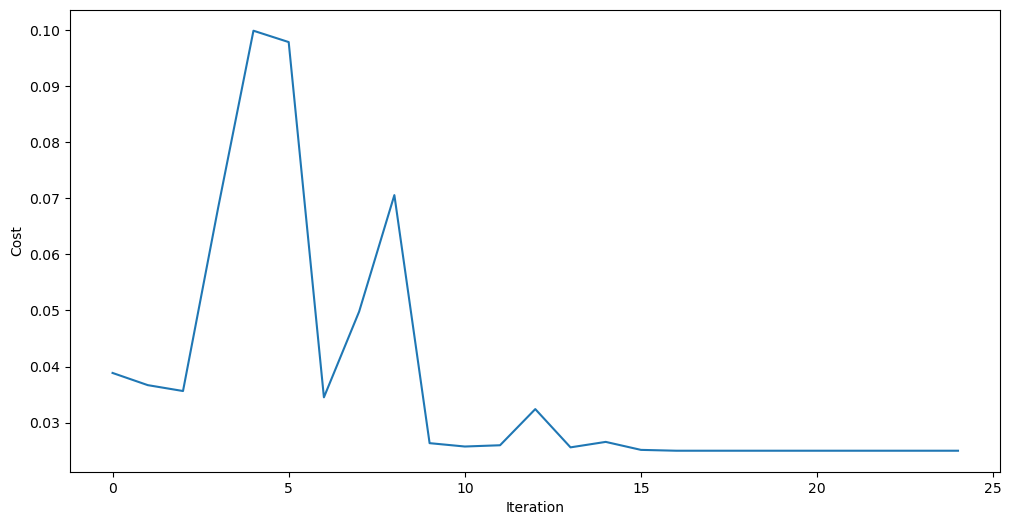

In [22]:
"""
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

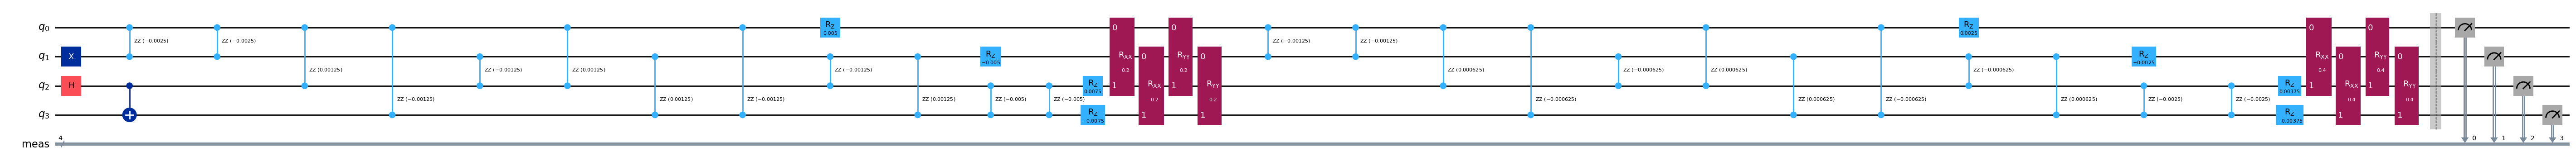

In [33]:
optimized_circuit = candidate_circuit.assign_parameters(init_params)
optimized_circuit.draw("mpl", fold=False, idle_wires=False)

In [34]:

sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub = (optimized_circuit,)
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val / shots for key, val in counts_int.items()}
final_distribution_bin = {key: val / shots for key, val in counts_bin.items()}
print(final_distribution_int)

{11: 0.1615, 2: 0.3355, 8: 0.1619, 14: 0.3411}


In [35]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]


keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, num_qubits)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 1, 1, 1]


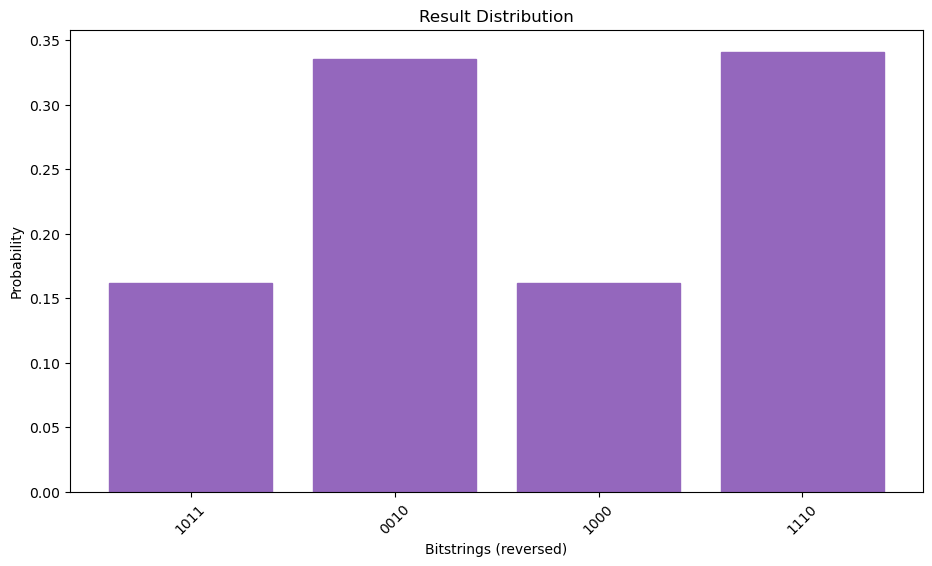

In [36]:
matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p[0])].set_color("tab:purple")
plt.show()

In [37]:
eigenvalues, eigenvectors = np.linalg.eig(cost_hamiltonian)
ground_energy = min(eigenvalues).real
num_solutions = eigenvalues.tolist().count(ground_energy)
index_solutions = np.where(eigenvalues == ground_energy)[0].tolist()
print(f"The ground energy of the Hamiltonian is {ground_energy}")
print(f"The number of solutions of the problem is {num_solutions}")
print(f"The list of the solutions based on their index is {index_solutions}")

The ground energy of the Hamiltonian is -0.07500000000000001
The number of solutions of the problem is 6
The list of the solutions based on their index is [0, 1, 3, 12, 13, 15]


In [38]:
def decimal_to_binary(decimal_list, n):
    return [bin(num)[2:].zfill(n) for num in decimal_list]

counts_list=counts_bin
# Convert the solutions to quantum states
states_solutions = decimal_to_binary(index_solutions, num_qubits)
# Sort the dictionary items by their counts in descending order
sorted_states = sorted(counts_list.items(), key=lambda item: item[1], reverse=True)
# Take the top 'num_solutions' entries
best_solution=2
top_states = sorted_states[:best_solution]
# Extract only the states keys from the top entries
qaoa_ground_states = sorted([state for state, count in top_states])
#states_solutions_short = [states_solutions[x][len(states_solutions[1])-5:] for x in range(len(states_solutions))]

print(f"The analytical solutions for the Max-cut problem are: {states_solutions}")
print(f"The QAOA ground states solutions for the Max-cut are: {qaoa_ground_states}")

The analytical solutions for the Max-cut problem are: ['0000', '0001', '0011', '1100', '1101', '1111']
The QAOA ground states solutions for the Max-cut are: ['0010', '1110']


In [28]:
def decimal_to_binary(decimal_list, n):
    return [bin(num)[2:].zfill(n) for num in decimal_list]

counts_list=counts_bin
# Convert the solutions to quantum states0010
states_solutions = decimal_to_binary(index_solutions, num_qubits)
# Sort the dictionary items by their counts in descending order
sorted_states = sorted(counts_list.items(), key=lambda item: item[1], reverse=True)
# Take the top 'num_solutions' entries
top_states = sorted_states[:num_solutions]
# Extract only the states keys from the top entries
qaoa_ground_states = sorted([state for state, count in top_states])
#states_solutions_short = [states_solutions[x][len(states_solutions[1])-5:] for x in range(len(states_solutions))]

print(f"The analytical solutions for the Max-cut problem are: {states_solutions}")
print(f"The QAOA ground states solutions for the Max-cut are: {qaoa_ground_states}")

The analytical solutions for the Max-cut problem are: ['0000', '0001', '0011', '1100', '1101', '1111']
The QAOA ground states solutions for the Max-cut are: ['0010', '1000', '1011', '1110']
